In [9]:
import pandas as pd
import json
import joblib
from io import StringIO
import os
import re
import string
import spacy
from tqdm import tqdm
import numpy as np

In [5]:
# Read wildchat_en_cleaned data
wildchat_en_path = "/Users/hoyiwong/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofWaterloo/Jiahe Huang - MSE 641 Project Data/wildchat_en_cleaned.jsonl"
wildchat_en = pd.read_json(wildchat_en_path, lines=True)

# Data Prepocessing

In [6]:
# Basic data inspection for wildchat_en dataset

print("Total rows:", wildchat_en.shape[0]) # Total number of rows

duplicate_count = wildchat_en["conversation_id"].duplicated().sum() # Count duplicate conversation_id entries
print("Duplicate conversation_id count:", duplicate_count)

turn_min, turn_max = wildchat_en["turn"].agg(["min", "max"]) # Show range of 'turn' 
print(f"Turn column range: {turn_min} to {turn_max}")

true_toxic = wildchat_en["toxic"].sum() # Count of rows with redacted == True
print("Total True in 'toxic':", true_toxic)

true_redacted = wildchat_en["redacted"].sum() # Count of rows with redacted == True
print("Total True in 'redacted':", true_redacted)

Total rows: 284168
Duplicate conversation_id count: 0
Turn column range: 1 to 78
Total True in 'toxic': 0
Total True in 'redacted': 2580


In [ ]:
# Remove unnecessary columns
wildchat_en_cleaned= wildchat_en.drop(columns=["language", "openai_moderation", "detoxify_moderation", "toxic", "redacted"])

In [8]:
# Split conversation into prompt and response coloumn

# Create empty list for result
rows = []

for row in wildchat_en.itertuples(index=False):
    convo = row.conversation
    prompts = []
    responses = []

    i = 0
    while i < len(convo) - 1:
        user, assistant = convo[i], convo[i + 1]
        if user["role"] == "user" and assistant["role"] == "assistant":
            prompts.append(user["content"])
            responses.append(assistant["content"])
            i += 2
        else:
            i += 1

    # Combine all turns into single prompt/response thread
    rows.append((
        row.conversation_id,
        row.model,
        row.timestamp,
        row.turn,
        "\n\n".join(prompts),
        "\n\n".join(responses),
        row.toxic,
        row.redacted,
    ))

# Convert to DataFrame
flattened_df = pd.DataFrame(rows, columns=[
    "conversation_id", "model", "timestamp", "turn", "prompt", "response", "toxic", "redacted",
])

In [9]:
# Convert all text to lowercase
flattened_df["prompt"] = flattened_df["prompt"].str.lower()
flattened_df["response"] = flattened_df["response"].str.lower()

In [10]:
# Remove all punctuation and special characters
RE_PUNCT = re.compile(f"[{re.escape(string.punctuation)}]")
RE_MOJIBAKE = re.compile(r"[^\w\s]{3,}")

def remove_encoding_garbage(text):
    if not isinstance(text, str):
        return ""

    # ASCII encode-decode strip (mojibake nuke)
    text = text.encode("ascii", "ignore").decode("utf-8", "ignore")

    # Fast regex cleanup
    text = RE_PUNCT.sub("", text)
    text = RE_MOJIBAKE.sub("", text)

    return text.strip()

# Append to prompt and response coloumns
flattened_df["prompt"] = flattened_df["prompt"].apply(remove_encoding_garbage)
flattened_df["response"] = flattened_df["response"].apply(remove_encoding_garbage)

In [4]:
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /Users/hoyiwong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hoyiwong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hoyiwong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# POS-filtered Lemmatization

In [2]:
# Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Define function for POS-filtered lemmatization 
def pos_filtered_lemmatizer(text):
    # Remove non-alphabetic characters (retain space)
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    doc = nlp(text)
    return " ".join([
        token.lemma_ for token in doc
        if token.pos_ in {"NOUN", "VERB"}  # Filter out ADJ, ADV, etc.
        and not token.is_stop
        and token.is_alpha
    ])

# Load dataset
flattened_df = pd.read_json("data/wildchat_en_cleaned.jsonl", lines=True)

# Checking progress
tqdm.pandas(desc="Progress")

# Lemmatized 'prompt' and 'response' columns
flattened_df["prompt"] = flattened_df["prompt"].progress_apply(pos_filtered_lemmatizer)

# Save output 
flattened_df.to_json("data/wildchat_en_lemmatized.jsonl", orient="records", lines=True, force_ascii=False)

Progress: 100%|██████████| 284168/284168 [1:12:26<00:00, 65.37it/s] 


In [ ]:
# Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Load dataset
flattened_df = pd.read_json("data/wildchat_en_lemmatized.jsonl", lines=True)
flattened_df = flattened_df.drop(columns=["toxic", "redacted"])

# Efficient lemmatization function using spaCy pipe
def lemmatize_full(texts, n_process=2, batch_size=300):
    return [
        " ".join(token.lemma_ for token in doc if token.is_alpha)
        for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts), desc="Progress")
    ]

# Apply to 'prompt' and 'response'
flattened_df["prompt"] = lemmatize_full(flattened_df["prompt"].fillna(""))
flattened_df["response"] = lemmatize_full(flattened_df["response"].fillna(""))

# Save output
flattened_df.to_json("data/wildchat_en_lemmatized.jsonl", orient="records", lines=True, force_ascii=False)

Progress: 100%|██████████| 284168/284168 [1:19:55<00:00, 59.26it/s]  


In [ ]:
# Checking sample result
df = pd.read_json("data/wildchat_en_lemmatized.jsonl", lines=True)

# Randomly sample 20 rows
sample_df = df.sample(n=20, random_state=42)

# Save to CSV
sample_df.to_csv("data/sample_wildchat_en_lemmatized_sample.csv", index=False)

# Remove Stop Words

In [8]:
from nltk.corpus import stopwords

# Make sure stopwords are available
nltk.download("stopwords")
nltk.download("punkt")

# Load English stopwords
stop_words = set(stopwords.words("english"))
stop_words.update(["prompt", "ar", "hi", "pleas"]) # Update customize stopwords

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.Defaults.stop_words |= stop_words

# Define remove stopwords function
def remove_stopwords(texts, n_process=2, batch_size=100):
    cleaned = []
    for doc in tqdm(nlp.pipe(texts, n_process=n_process, batch_size=batch_size), total=len(texts), desc="Removing stopwords"):
        cleaned.append(" ".join(token.text for token in doc if not token.is_stop and token.is_alpha))
    return cleaned

# Load dataset
flattened_df = pd.read_json("data/wildchat_en_lemmatized.jsonl", lines=True)

# Apply with progress
flattened_df["prompt"] = remove_stopwords(flattened_df["prompt"].fillna(""))
flattened_df["response"] = remove_stopwords(flattened_df["response"].fillna(""))

# Save cleaned data
flattened_df.to_json("data/wildchat_cleaned_final.jsonl", orient="records", lines=True, force_ascii=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoyiwong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hoyiwong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Removing stopwords: 100%|██████████| 284168/284168 [1:20:09<00:00, 59.08it/s]  


In [9]:
# Save a preview sample to CSV
flattened_df.head(20).to_csv("data/wildchat_cleaned_final_sample.csv", index=False)

# Phase Detection

In [1]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [6]:
import itertools
from collections import Counter

# Load data
flattened_df = pd.read_json("data/wildchat_cleaned_final.jsonl", lines=True)

# Combine 'prompt' and 'response' into conversation
flattened_df["conversation"] = flattened_df["prompt"].fillna("") + " " + flattened_df["response"].fillna("")

# Tokenize by whitespace
tokenized_texts = [text.split() for text in flattened_df["conversation"]]

# Train Gensim Phrases mo
bigram_model = Phrases(tokenized_texts, min_count=10, threshold=15)
trigram_model = Phrases(bigram_model[tokenized_texts], min_count=10, threshold=10)
bigram_phraser = Phraser(bigram_model)
trigram_phraser = Phraser(trigram_model)

# Apply phrasers
flattened_df["phrase_tokens"] = [
    trigram_phraser[bigram_phraser[tokens]] for tokens in tqdm(tokenized_texts, desc="Applying Phrase Detection")
]

# Join tokens back into string format
flattened_df["phrase_text"] = [" ".join(tokens) for tokens in flattened_df["phrase_tokens"]]

# Save final version
flattened_df.to_json("data/wildchat_phrase_detected.jsonl", orient="records", lines=True, force_ascii=False)

Applying Phrase Detection: 100%|██████████| 284168/284168 [02:06<00:00, 2238.06it/s] 


In [7]:
# Checking
import itertools
from collections import Counter

# Count detected phrases with underscores
all_phrases = list(itertools.chain.from_iterable(flattened_df["phrase_tokens"]))
phrase_counts = Counter([tok for tok in all_phrases if "_" in tok])

# Show top 30 phrases
print("\nTop Phrases:")
for phrase, count in phrase_counts.most_common(30):
    print(f"{phrase}: {count}")


Top Phrases:
v_imagine: 42258
capture_camera_mm_lens: 41178
midjourney_ai_generate_image: 29421
write_line_use: 29417
generator_ai_midjourney_create: 29413
form_place_comma_v: 29411
image_visualize_concept_provide: 29410
adhere_structure_format_follow: 29410
guideline_use_word_description: 29410
ai_language_model: 26170
image_v: 20758
use_image_image: 20607
imagine_halo_reach_landscape: 20606
spartan_fall_enemy_smoke: 20605
fire_background_emphasize_determination: 20605
bravery_environment_blend_chaos: 20605
use_niji_art_style: 20603
beauty_illustration_art_v: 20603
v_style_formatting: 20602
follow_structure_imagine_task: 20602
capture_essence_beauty_composition: 20589
scene_mood_feel_atmosphere: 20588
depth_field_composition_focus: 20588
woman_coffee_shop_sip: 20588
cup_steam_coffee_sunlight: 20588
stream_window_color_tone: 20588
vintage_decor_armchair_table: 20588
bookshelf_fill_porcelain_teacup: 20588
hint_coffee_bean_air: 20588
focus_face_hand_painting: 20588


# Text Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from scipy.sparse import vstack

# Load data
flattened_df = pd.read_json("data/wildchat_phrase_detected.jsonl", lines=True)
conversation = flattened_df["phrase_text"].tolist()

# Init vectorizer 
vectorizer = TfidfVectorizer(
    max_features=3000,        # fewer dimensions = faster
    ngram_range=(1, 2),       # unigrams + bigrams only
    lowercase=False,
    max_df=0.95,
    min_df=10,
    norm='l2',
    use_idf=True,
    smooth_idf=True
)

# Fit on full data
print("Fitting vectorizer...")
vectorizer.fit(conversation)

# Transform in chunks to reduce memory usage
chunk_size = 10000
X_parts = []

with tqdm(total=len(conversation), desc="TF-IDF transforming") as pbar:
    for i in range(0, len(conversation), chunk_size):
        chunk = conversation[i:i+chunk_size]
        X_chunk = vectorizer.transform(chunk)
        X_parts.append(X_chunk)
        pbar.update(len(chunk))

X_convo = vstack(X_parts)

# Save vectorizer and matrix
joblib.dump(vectorizer, "data/tfidf_vectorizer_fast.pkl")
joblib.dump(X_convo, "data/tfidf_matrix_fast.pkl")

print("Matrix shape:", X_convo.shape)
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))

Fitting vectorizer...


TF-IDF transforming: 100%|██████████| 284168/284168 [01:10<00:00, 4025.07it/s]


Matrix shape: (284168, 3000)
Vocabulary size: 3000


In [3]:
# Get feature names and average TF-IDF score
feature_names = np.array(vectorizer.get_feature_names_out())
mean_tfidf_scores = X_convo.mean(axis=0).A1

# Check Top 50 
top_indices = mean_tfidf_scores.argsort()[::-1][:50]
top_features = feature_names[top_indices]
top_scores = mean_tfidf_scores[top_indices]

# Print the result
print("Top 20 Most Important TF-IDF Features in conversation:")
for feature, score in zip(top_features, top_scores):
    print(f"{feature:<30} {score:.4f}")

NameError: name 'vectorizer' is not defined

# Dimensionality Reduction

# components for 90% variance: 0
# components for 95% variance: 0


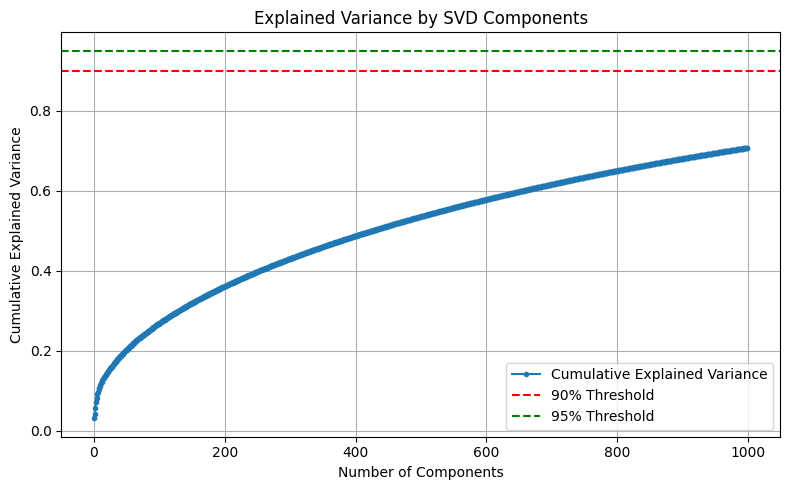

In [ ]:
# determine n_components
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Load TF-IDF matrix
X_convo = joblib.load("data/tfidf_matrix_fast.pkl")

# Fit SVD
svd = TruncatedSVD(n_components=1000, random_state=42)
X_reduced = svd.fit_transform(X_convo)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Find cutoff points
n_90 = np.argmax(cumulative_variance >= 0.90)
n_95 = np.argmax(cumulative_variance >= 0.95)

print(f"# components for 90% variance: {n_90}")
print(f"# components for 95% variance: {n_95}")

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, label="Cumulative Explained Variance", marker='o', markersize=3)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Threshold')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by SVD Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Calculate cumulative variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Safe search for threshold
def find_threshold_component(threshold):
    if cumulative_variance[-1] < threshold:
        return None  # Not achievable
    return np.argmax(cumulative_variance >= threshold)

n_90 = find_threshold_component(0.90)
n_95 = find_threshold_component(0.95)

print(f"# components for 90% variance: {n_90 if n_90 is not None else 'Not reached'}")
print(f"# components for 95% variance: {n_95 if n_95 is not None else 'Not reached'}")

# Save reduced matrix + model
joblib.dump(X_reduced, "data/svd_matrix_1000.pkl")
joblib.dump(svd, "data/svd_model_1000.pkl")

# components for 90% variance: Not reached
# components for 95% variance: Not reached


['data/svd_model_1000.pkl']

# K-mean Clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load phrase-detected data and vectorized TF-IDF matrix
flattened_df = pd.read_json("data/wildchat_phrase_detected.jsonl", lines=True)
X_reduced = joblib.load("data/svd_matrix_1000.pkl")

# K-Means clustering (set baseline k = 20)
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_reduced)

# Add cluster labels with progress
print("Progress")
tqdm.pandas(desc="Labeling Rows")
flattened_df["cluster"] = list(tqdm(cluster_labels, desc="Copying Labels"))

# Attach clusters to original data
flattened_df["cluster"] = cluster_labels

# Save the clustered data
flattened_df.to_json("data/wildchat_clustered.jsonl", orient="records", lines=True, force_ascii=False)

# Print samples
for i in range(k):
    print(f"\n🔹 Cluster {i}:")
    examples = flattened_df[flattened_df["cluster"] == i]["phrase_text"].head(5)
    for text in examples:
        print(f"  - {text[:100]}...")

Progress


Copying Labels: 100%|██████████| 284168/284168 [00:00<00:00, 3786388.61it/s]



🔹 Cluster 0:
  - write_article guide book use tram style_phrase_avoidance sentence title aboard moroccan tram compreh...
  - word_limit_term memory_term_memory save information file_want_recall event think event help remember...
  - write_article guide book airport style_phrase_avoidance sentence title navigating way moroccos airpo...
  - write_article guide book time visit style_phrase_avoidance sentence title best time visit morocco bo...
  - zhege biaozi fengle translation zhege biaozi fengle chinese chinese language...

🔹 Cluster 1:
  - model use ai_language_model based_openais generative_pretrained_transformer...
  - ckpt machine_learn file ckpt checkpoint machine_learning file typically_contains weights_biases trai...
  - ckpt file machine_learning ckpt file short checkpoint file machine_learning store current_state trai...
  - produce m_sorry_ai_language model unable_physically produce assist need help python linear_regressio...
  - temperature_topp nucleus_sampling language_mo

# Evaluation

In [6]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples

# Internal Validation Metrics
print(f"Internal Validation Metrics (k={k}):")

sil_score = silhouette_score(X_reduced, cluster_labels)
calinski = calinski_harabasz_score(X_reduced, cluster_labels)
davies = davies_bouldin_score(X_reduced, cluster_labels)

print(f"Silhouette Score:         {sil_score:.4f}")
print(f"Calinski-Harabasz Index:  {calinski:.2f}")
print(f"Davies-Bouldin Index:     {davies:.4f}")

Internal Validation Metrics (k=20):
Silhouette Score:         0.0495
Calinski-Harabasz Index:  2827.11
Davies-Bouldin Index:     4.7356


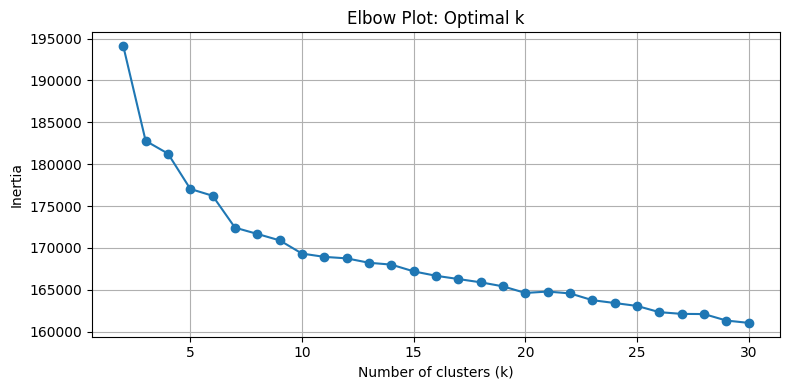

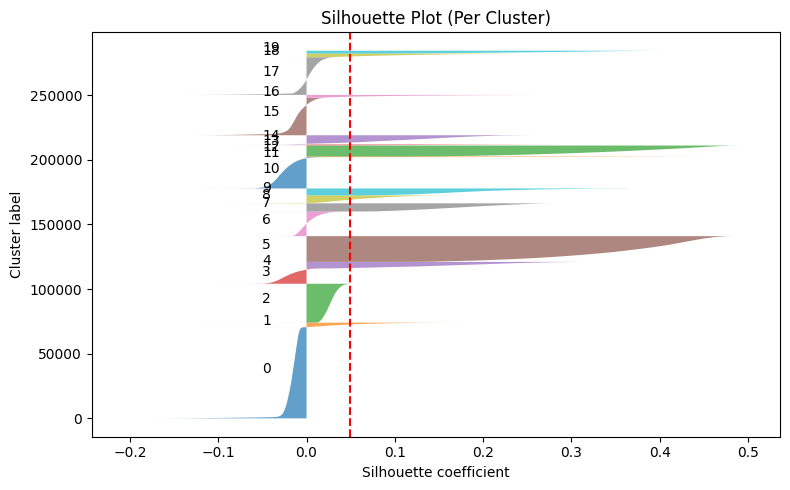

In [10]:
import matplotlib.pyplot as plt

# Elbow Method Plot
def elbow_plot(X, max_k=30):
    distortions = []
    for i in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init="auto")
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.title("Elbow Plot: Optimal k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Silhouette Plot
def silhouette_plot(X, labels, k):
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 10

    plt.figure(figsize=(8, 5))
    for i in range(k):
        ith_cluster_sil_vals = sample_silhouette_values[labels == i]
        ith_cluster_sil_vals.sort()
        size_cluster_i = ith_cluster_sil_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_sil_vals, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=sil_score, color="red", linestyle="--")
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster label")
    plt.title("Silhouette Plot (Per Cluster)")
    plt.tight_layout()
    plt.show()

# Run both visual tools
elbow_plot(X_reduced, max_k=30)
silhouette_plot(X_reduced, cluster_labels, k)

# Cluster Analysis

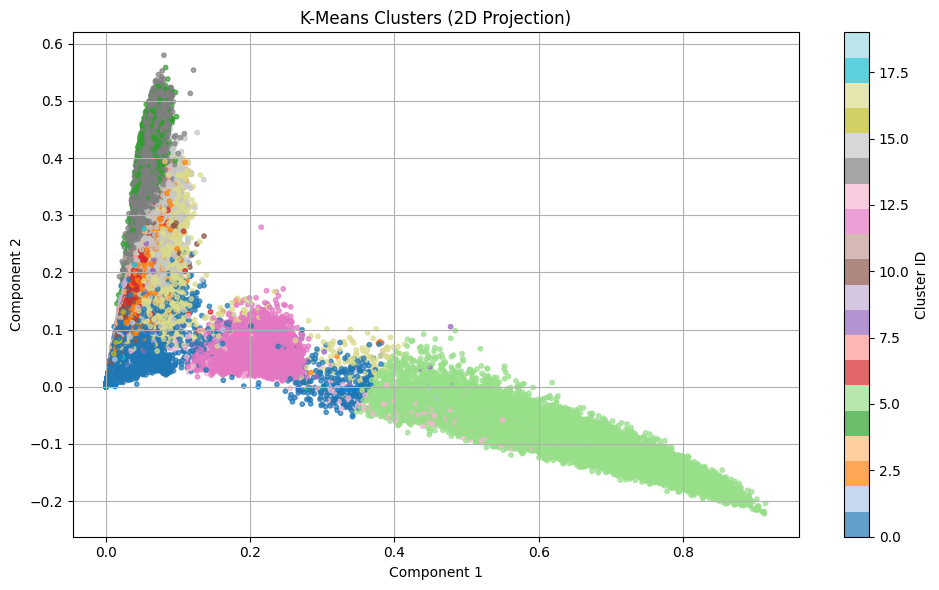

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Reduce to 2D for plotting (if not already 2D)
plotter = TruncatedSVD(n_components=2, random_state=42)
X_2d = plotter.fit_transform(X_reduced)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab20', s=10, alpha=0.7)
plt.title("K-Means Clusters (2D Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()
